### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve

Read the spectral data

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Remove the noise from the spectra using Savitzky–Golay-filtering

In [41]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 7
poly_order = 3

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = savgol_filter(df['Absorbance'], window_size, poly_order)

Then carry out baseline correction using Asymmetric Least Squares Smoothing to remove the background fluorescence from the spectra.

In [124]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

lam = 10**3  # Adjust the regularisation parameter
p = 0.01    # Adjust the asymmetry parameter
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: baseline_als(x, lam=lam, p=p))

## 1 Sample Example

In [159]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status  \
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia   
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia   
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia   
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia   
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia   
...              ...   ...         ...         ...       ...            ...   
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia   
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia   
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia   
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia   
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia   

         Smoothed_Absorbance  Baseline_Corrected_Ab

Find the peaks of each the differently smoothed spectra

In [160]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'], height=height, distance=distance)
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'], height=height, distance=distance)
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'], height=height, distance=distance)

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

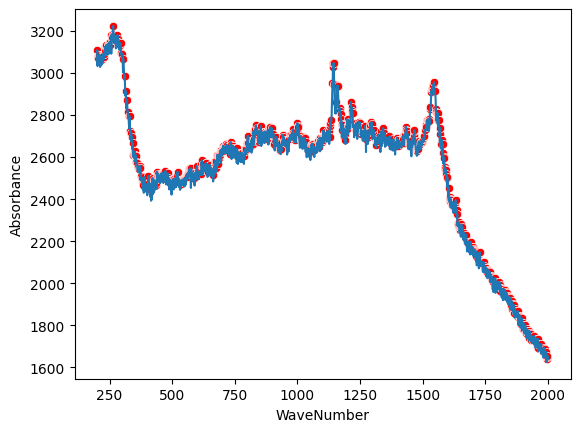

In [161]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

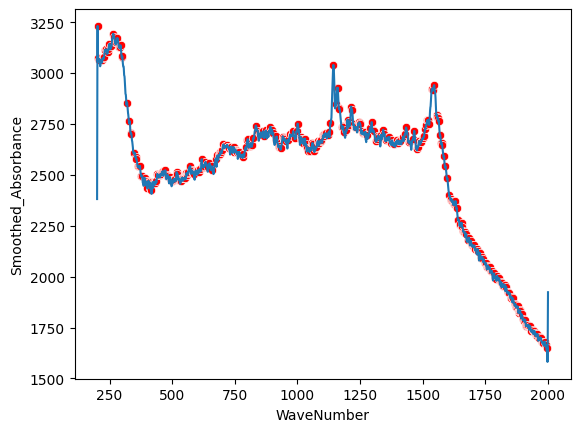

In [162]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

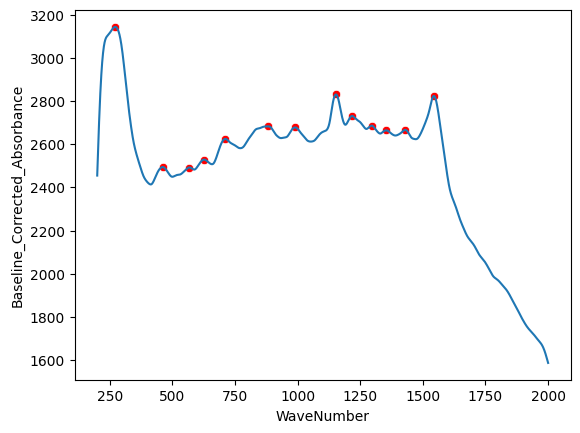

In [163]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

#### Machine Learning Test

In [164]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier

In [165]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

Create a Column for each Wavelength

In [166]:
raw_df = df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
raw_df.columns.name = None

smooth_df = df.pivot(index='SpecID', columns='WaveNumber', values='Smoothed_Absorbance').reset_index()
smooth_df.columns.name = None

baseline_df = df.pivot(index='SpecID', columns='WaveNumber', values='Baseline_Corrected_Absorbance').reset_index()
baseline_df.columns.name = None

Add the statuses back.

In [167]:
statuses = df[['SpecID', 'Status']].drop_duplicates()

raw_df = pd.merge(raw_df, statuses, on='SpecID')
raw_df = raw_df.set_index('SpecID')

smooth_df = pd.merge(smooth_df, statuses, on='SpecID')
smooth_df = smooth_df.set_index('SpecID')

baseline_df = pd.merge(baseline_df, statuses, on='SpecID')
baseline_df = baseline_df.set_index('SpecID')

### Compare the techniques on different models

In [168]:
def train_random_forest(df):
    
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

    # Initializing and fitting the Random Forest classifier
    rf = RandomForestClassifier(random_state=1234, n_estimators=500)
    rf.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = rf.predict(X_test)

    # Calculating and printing evaluation metrics
    calculate_metrics(y_test, y_pred)

In [152]:
train_random_forest(raw_df)

Overall Accuracy: 0.8637110016420362


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.86      0.84      0.85       203
 Hypoglycemia       0.87      0.85      0.86       200
       Normal       0.86      0.90      0.88       206

     accuracy                           0.86       609
    macro avg       0.86      0.86      0.86       609
 weighted avg       0.86      0.86      0.86       609


Confusion Matrix:
[[170  18  15]
 [ 14 171  15]
 [ 14   7 185]]


In [153]:
train_random_forest(smooth_df)

Overall Accuracy: 0.8587848932676518


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.85      0.82      0.83       203
 Hypoglycemia       0.87      0.86      0.86       200
       Normal       0.86      0.90      0.88       206

     accuracy                           0.86       609
    macro avg       0.86      0.86      0.86       609
 weighted avg       0.86      0.86      0.86       609


Confusion Matrix:
[[166  20  17]
 [ 14 172  14]
 [ 15   6 185]]


In [154]:
train_random_forest(baseline_df)

Overall Accuracy: 0.8555008210180624


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.83      0.83      0.83       203
 Hypoglycemia       0.87      0.83      0.85       200
       Normal       0.86      0.90      0.88       206

     accuracy                           0.86       609
    macro avg       0.86      0.86      0.86       609
 weighted avg       0.86      0.86      0.86       609


Confusion Matrix:
[[169  19  15]
 [ 19 167  14]
 [ 16   5 185]]


In [155]:
def train_extra_trees(df):
    
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

    # Initializing and fitting the Random Forest classifier
    et = ExtraTreesClassifier(random_state=1234, n_estimators=1234)
    et.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = et.predict(X_test)

    # Calculating and printing evaluation metrics
    calculate_metrics(y_test, y_pred)

In [156]:
train_extra_trees(raw_df)

Overall Accuracy: 0.8768472906403941


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.86      0.87      0.87       203
 Hypoglycemia       0.90      0.87      0.89       200
       Normal       0.87      0.89      0.88       206

     accuracy                           0.88       609
    macro avg       0.88      0.88      0.88       609
 weighted avg       0.88      0.88      0.88       609


Confusion Matrix:
[[177  11  15]
 [ 14 174  12]
 [ 15   8 183]]


In [157]:
train_extra_trees(smooth_df)

Overall Accuracy: 0.8719211822660099


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.85      0.87      0.86       203
 Hypoglycemia       0.89      0.86      0.87       200
       Normal       0.88      0.89      0.89       206

     accuracy                           0.87       609
    macro avg       0.87      0.87      0.87       609
 weighted avg       0.87      0.87      0.87       609


Confusion Matrix:
[[176  14  13]
 [ 17 172  11]
 [ 15   8 183]]


In [158]:
train_extra_trees(baseline_df)

Overall Accuracy: 0.8702791461412152


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.84      0.87      0.85       203
 Hypoglycemia       0.89      0.86      0.88       200
       Normal       0.88      0.88      0.88       206

     accuracy                           0.87       609
    macro avg       0.87      0.87      0.87       609
 weighted avg       0.87      0.87      0.87       609


Confusion Matrix:
[[176  14  13]
 [ 17 172  11]
 [ 17   7 182]]
